Decision Tree Accuracy: 0.7912087912087912
[[41  8]
 [11 31]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        49
           1       0.79      0.74      0.77        42

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91

ROC AUC (Decision Tree): 0.8673469387755102
AdaBoost Accuracy: 0.8131868131868132
[[42  7]
 [10 32]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        49
           1       0.82      0.76      0.79        42

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91

ROC AUC (AdaBoost): 0.9050048590864918
Mixed Accuracy | p=0.95, q=0.05: 0.7912
Mixed Accuracy | p=0.90, q=0.10: 0.7912
Mixed Accuracy | p=0.85, q=0.15: 0.7912
Mixed Accuracy | p=0.80,

/Users/rishimane/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


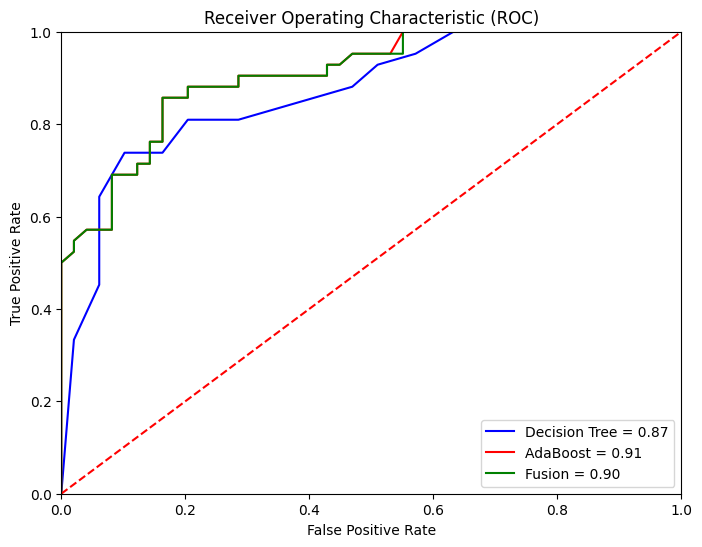

In [1]:
# Binary Class Fusion Model-3 (ADA + DT) using Weighted Score Fusion

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

# Load dataset
dataset = pd.read_csv("./binary classification.csv")

# Split features (0-12) and target (13th column)
X = dataset.iloc[:, 0:13].values
y = dataset.iloc[:, 13].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)

# StandardScaler (not used for tree-based models, but defined)
sc = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

# --------------------------
# Decision Tree Model
# --------------------------
model1 = DecisionTreeClassifier(
    criterion='gini',
    max_depth=8,
    max_features=8,
    min_samples_leaf=7,
    splitter='random'
)

# Train Decision Tree
model1.fit(X_train, y_train)
predictions1 = model1.predict_proba(X_test)
y_pred1 = model1.predict(X_test)

# Metrics for Decision Tree
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

fpr1, tpr1, _ = roc_curve(y_test, predictions1[:, 1])
roc_auc1 = auc(fpr1, tpr1)
print("ROC AUC (Decision Tree):", roc_auc1)

# --------------------------
# AdaBoost Model
# --------------------------
model2 = AdaBoostClassifier(n_estimators=200, learning_rate=0.01)

# Train AdaBoost
model2.fit(X_train, y_train)
predictions2 = model2.predict_proba(X_test)
y_pred2 = model2.predict(X_test)

# Metrics for AdaBoost
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

fpr2, tpr2, _ = roc_curve(y_test, predictions2[:, 1])
roc_auc2 = auc(fpr2, tpr2)
print("ROC AUC (AdaBoost):", roc_auc2)

# --------------------------
# Weighted Fusion
# --------------------------
# Tune weights p and q (p + q = 1)
p = 1.0
best_score = 0
best_p = 0
best_q = 0

for i in range(20):
    p -= 0.05
    q = 1 - p

    mixed = predictions1[:, 1] * p + predictions2[:, 1] * q
    rounded_mixed = (mixed >= 0.5).astype(int)

    score = accuracy_score(y_test, rounded_mixed)
    print(f"Mixed Accuracy | p={p:.2f}, q={q:.2f}: {score:.4f}")

    if score > best_score:
        best_score = score
        best_p = p
        best_q = q

# Use best weights for final fusion
p = best_p
q = best_q
mixed = predictions1[:, 1] * p + predictions2[:, 1] * q
rounded_mixed = (mixed >= 0.5).astype(int)

# Metrics for Fusion
print("Final Fusion Accuracy:", accuracy_score(y_test, rounded_mixed))
print(confusion_matrix(y_test, rounded_mixed))
print(classification_report(y_test, rounded_mixed))

fpr, tpr, _ = roc_curve(y_test, mixed)
roc_auc = auc(fpr, tpr)
print("ROC AUC (Fusion):", roc_auc)

# --------------------------
# Plot ROC Curves
# --------------------------
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr1, tpr1, 'b', label=f'Decision Tree = {roc_auc1:.2f}')
plt.plot(fpr2, tpr2, 'r', label=f'AdaBoost = {roc_auc2:.2f}')
plt.plot(fpr, tpr, 'g', label=f'Fusion = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
